In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

In [2]:
path = 'stars_results/DR14_ASPC'
df = pd.read_csv(os.path.join(path, 'stars/results.csv'))
df.head()

,name,f_evol_16th,f_evol_50th,f_evol_84th,f_evol_ess_bulk,f_evol_ess_mean,f_evol_ess_sd,f_evol_ess_tail,f_evol_hpd_3%,f_evol_hpd_97%,...,mhs_ess_mean,mhs_ess_sd,mhs_ess_tail,mhs_hpd_3%,mhs_hpd_97%,mhs_mcse_mean,mhs_mcse_sd,mhs_mean,mhs_r_hat,mhs_sd
0,KIC5950854,0.763321,0.915235,1.046385,814.365176,807.303557,801.092467,2283.722583,0.665883,1.148091,...,16114.286060,16114.286060,12091.605099,-0.286714,-0.014441,0.000571,0.000404,-0.151989,1.000285,0.072446
1,KIC3942719,1.793372,1.842284,1.875486,1208.655610,1313.961699,1300.915979,4350.549601,1.745100,1.902267,...,4721.370081,4610.206042,5994.090706,-0.399115,-0.182095,0.000851,0.000609,-0.286317,1.001281,0.058497
2,KIC4457351,1.730574,1.791438,1.841019,1282.096402,1346.560937,1332.039675,3487.793276,1.684641,1.875507,...,18653.945354,16806.701632,12661.388740,-0.346223,-0.166987,0.000347,0.000258,-0.255532,1.000415,0.047389
3,KIC3223000,0.241799,0.427376,0.608999,1018.251812,1026.676044,1026.676044,1525.716817,0.117327,0.721454,...,11134.823647,11134.823647,12483.149321,-0.261360,-0.000487,0.000666,0.000471,-0.128199,1.000233,0.070297
4,KIC7429287,1.392368,1.515212,1.632316,920.639688,941.100703,926.034823,2818.445597,1.318749,1.697221,...,13411.201816,12436.152423,11806.379119,-0.416528,-0.157931,0.000604,0.000443,-0.284552,1.000286,0.069892


In [3]:
def get_var(var_name):
    x = df[f'{var_name}_50th'].values
    return x, np.max([df[f'{var_name}_84th'].values - x, x - df[f'{var_name}_16th'].values], axis=0)

In [4]:
y, y_unc = get_var('yi')
z, z_unc = get_var('zi')

<ErrorbarContainer object of 3 artists>

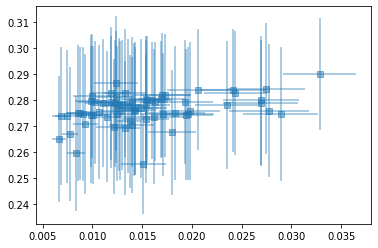

In [5]:
fig, ax = plt.subplots()
ax.errorbar(z, y, xerr=z_unc, yerr=y_unc, linestyle='None', marker='s', alpha=0.5)

In [6]:
mlt, mlt_unc = get_var('mlt')

In [29]:
with pm.Model() as model:
    yp = pm.Normal('yp', 0.247, 0.001)
    dydz = pm.Deterministic('dydz', 4.0 * pm.Beta('dydz_offset', 1.2, 1.2))
    sigma_yi = pm.Lognormal('sigma_yi', 0.01, 1.0)

    mu_mlt = pm.Deterministic('mu_mlt', 1.5 + pm.Beta('mu_mlt_offset', 1.2, 1.2))
    sigma_mlt = pm.Lognormal('sigma_mlt', 0.1, 1.0)
    
    z_latent = pm.Normal('z_latent', z, z_unc, shape=len(z))
    y_offset = pm.Normal('y_offset', 0.0, 1.0, shape=len(z))
    mu_yi = yp + dydz * z_latent
    y_pred = pm.Deterministic('y_pred', mu_yi + sigma_yi * y_offset)
    
    mlt_offset = pm.Normal('mlt_offset', 0.0, 1.0, shape=len(mlt))
    mlt_pred = pm.Deterministic('mlt_pred', mu_mlt + sigma_mlt * mlt_offset)
    
    y_obs = pm.Normal('y_obs', y_pred, y_unc, observed=y)
    mlt_obs = pm.Normal('mlt_obs', mlt_pred, mlt_unc, observed=mlt)

In [30]:
draws = 10000
chains = 2

with model:
    trace = pm.sample(draws=draws, chains=chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mlt_offset, y_offset, z_latent, sigma_mlt, mu_mlt_offset, sigma_yi, dydz_offset, yp]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.


/Users/ajl573/.virtualenvs/stellr/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


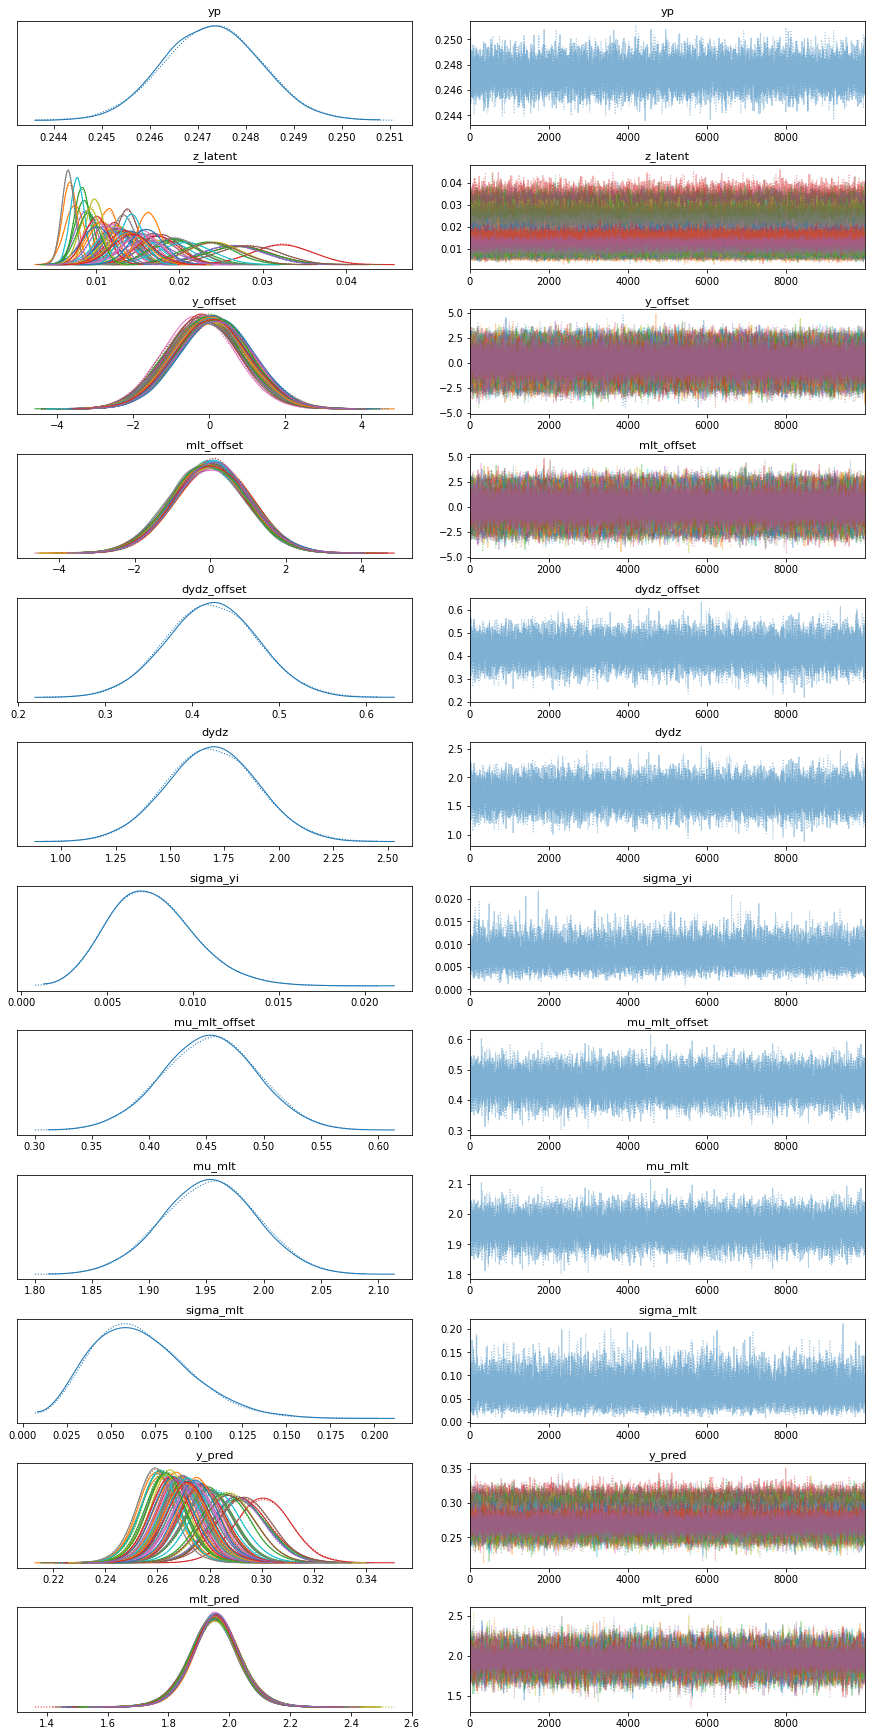

In [31]:
pm.traceplot(trace, compact=True);

In [32]:
stat_funcs = {
    '50th': np.median,
    '16th': lambda x: np.percentile(x, 16.0),
    '84th': lambda x: np.percentile(x, 84.0),
}

In [33]:
summary = pm.summary(trace, round_to='none', stat_funcs=stat_funcs)
summary.head()

/Users/ajl573/.virtualenvs/stellr/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,50th,16th,84th
yp,0.247306,0.000991,0.245457,0.249166,0.000006,0.000004,29270.884736,29270.884736,29279.374618,14377.553925,1.000079,0.247311,0.246320,0.248293
z_latent[0],0.012338,0.001922,0.008777,0.016003,0.000010,0.000008,34190.322799,32104.754993,34203.544229,12448.155626,1.000060,0.012330,0.010428,0.014253
z_latent[1],0.007439,0.001188,0.005182,0.009633,0.000007,0.000005,28351.570328,27217.088904,28344.529240,13120.122210,1.000020,0.007444,0.006267,0.008613
z_latent[2],0.008326,0.000914,0.006605,0.010038,0.000005,0.000004,31865.707018,30994.956381,31883.533932,13588.003724,1.000634,0.008325,0.007419,0.009229
z_latent[3],0.012163,0.001715,0.008983,0.015391,0.000009,0.000007,32674.809321,31746.000012,32673.984965,13411.261769,1.000061,0.012171,0.010466,0.013874


In [36]:
summary.to_csv(os.path.join(path, 'analysis/summary.csv'), index_label='var_name')

In [ ]:
phi = ['dydz', 'yp', 'sigma_yi', 'mu_mlt', 'sigma_mlt']

In [49]:
results = pm.summary(trace, var_names=phi, round_to='none', stat_funcs=stat_funcs)
# results = results.reset_index()
results

/Users/ajl573/.virtualenvs/stellr/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,50th,16th,84th
dydz,1.693032,0.207203,1.300726,2.082069,0.001329,0.000945,24303.929688,24042.346859,24306.782658,14215.993158,1.000138,1.691654,1.486645,1.897386
yp,0.247306,0.000991,0.245457,0.249166,0.000006,0.000004,29270.884736,29270.884736,29279.374618,14377.553925,1.000079,0.247311,0.246320,0.248293
sigma_yi,0.007644,0.002451,0.003216,0.012217,0.000017,0.000012,21520.099490,19280.404853,21534.368899,13824.246725,0.999941,0.007441,0.005238,0.010028
mu_mlt,1.953110,0.040498,1.875293,2.027568,0.000251,0.000177,26087.561429,26087.561429,26100.051563,14335.567051,1.000003,1.953504,1.912480,1.993259
sigma_mlt,0.067762,0.027455,0.019705,0.118266,0.000171,0.000130,25731.082156,22456.359842,25163.607353,13900.283232,1.000242,0.064634,0.040714,0.094739


In [77]:
res = {}
for idx, val in results.iterrows():
    res[idx] = val.to_frame().T.reset_index(drop=True)

In [80]:
results = pd.concat(res, axis=1)
results.columns = ['_'.join(multicol) for multicol in results.columns]
results

,dydz_mean,dydz_sd,dydz_hdi_3%,dydz_hdi_97%,dydz_mcse_mean,dydz_mcse_sd,dydz_ess_mean,dydz_ess_sd,dydz_ess_bulk,dydz_ess_tail,...,sigma_mlt_mcse_mean,sigma_mlt_mcse_sd,sigma_mlt_ess_mean,sigma_mlt_ess_sd,sigma_mlt_ess_bulk,sigma_mlt_ess_tail,sigma_mlt_r_hat,sigma_mlt_50th,sigma_mlt_16th,sigma_mlt_84th
0,1.693032,0.207203,1.300726,2.082069,0.001329,0.000945,24303.929688,24042.346859,24306.782658,14215.993158,...,0.000171,0.00013,25731.082156,22456.359842,25163.607353,13900.283232,1.000242,0.064634,0.040714,0.094739


In [81]:
results.to_csv(os.path.join(path, 'analysis/results.csv'), index=False)

In [82]:
pm.save_trace(trace, os.path.join(path, 'analysis/trace'), overwrite=True)

'stars_results/DR14_ASPC/analysis/trace'

Text(0.5, 0, 'sigma_mlt')

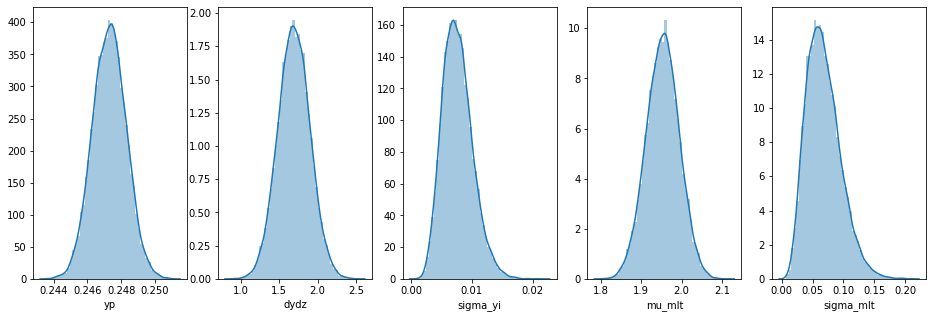

In [83]:
fig, ax = plt.subplots(1, 5, figsize=[16, 5])
sns.distplot(trace['yp'], ax=ax[0])
ax[0].set_xlabel('yp')
sns.distplot(trace['dydz'], ax=ax[1])
ax[1].set_xlabel('dydz')
sns.distplot(trace['sigma_yi'], ax=ax[2])
ax[2].set_xlabel('sigma_yi')
sns.distplot(trace['mu_mlt'], ax=ax[3])
ax[3].set_xlabel('mu_mlt')
sns.distplot(trace['sigma_mlt'], ax=ax[4])
ax[4].set_xlabel('sigma_mlt')

In [84]:
n_samples = 100
rand_ids = np.random.randint(0, chains*draws-1, size=(1, n_samples))

In [85]:
z_mod = np.array([[0.], [0.05]]) * np.ones((2, n_samples))
y_mod = trace['dydz'][rand_ids] * z_mod + trace['yp'][rand_ids]

In [86]:
y_upper = y_mod + trace['sigma_yi'][rand_ids]
y_lower = y_mod - trace['sigma_yi'][rand_ids]

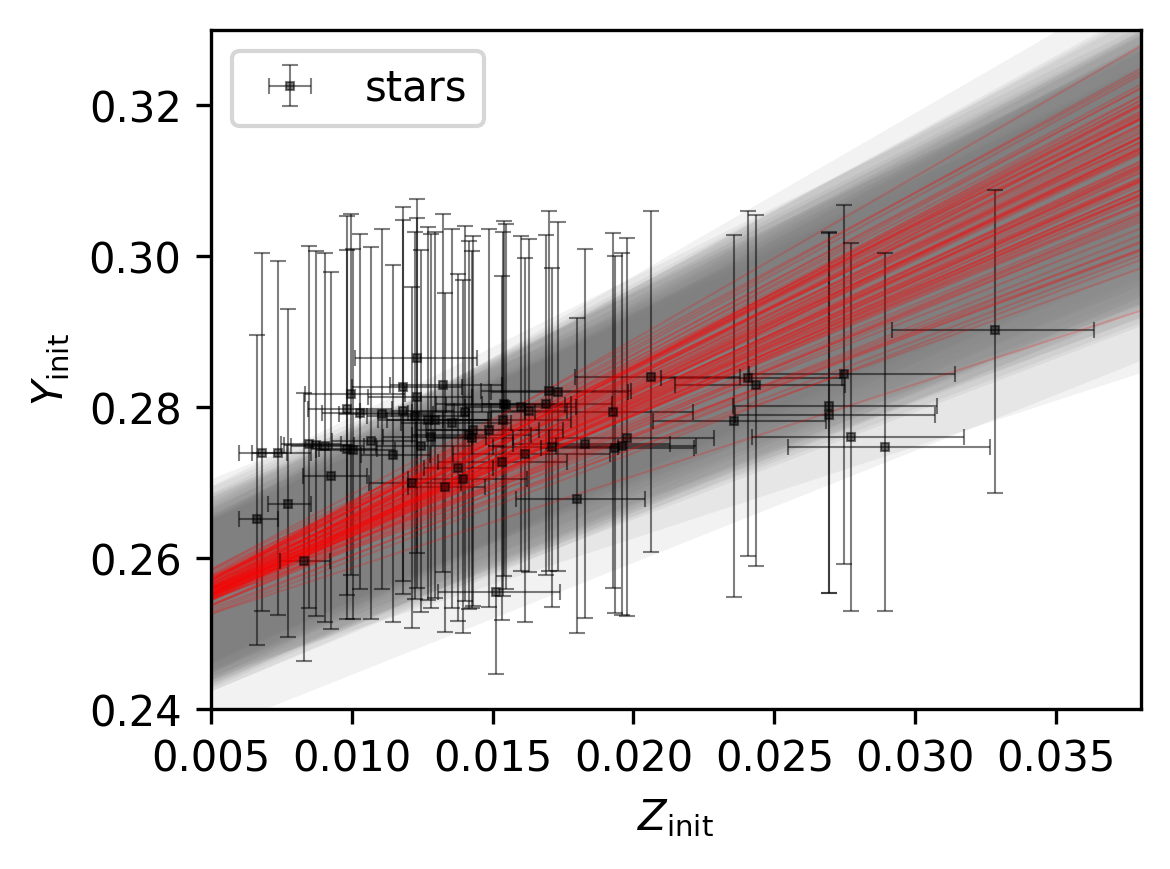

In [87]:
plt.figure(figsize=(4, 3), dpi=300)

for i in range(n_samples):
    plt.fill_between(z_mod[:, i], y_upper[:, i], y_lower[:, i], facecolor='grey', edgecolor='none', alpha=0.1)

l_mod = plt.plot(z_mod, y_mod, 'r', alpha=0.2, linewidth=0.5)

l_data = plt.errorbar(x=df['zi_50th'], y=df['yi_50th'],
             xerr=[df['zi_50th']-df['zi_16th'], df['zi_84th']-df['zi_50th']], 
             yerr=[df['yi_50th']-df['yi_16th'], df['yi_84th']-df['yi_50th']],
             linestyle='none', alpha=0.5, color='k',
             marker='s', markersize=2, elinewidth=0.5,
             capsize=2, label='stars', markeredgewidth=0.5,
#              zorder=1
             )

# if 'SUN' in df['name'].to_numpy():
#     s = df[df['name']=='SUN']
#     plt.plot(s['zi_50th'], s['yi_50th'], c='gold', marker=r'$\odot$', markersize=8,
#                  linestyle='none', markeredgewidth=0.5, zorder=3, label='sun'
#              )

plt.xlabel(r'$Z_\mathrm{init}$')
plt.ylabel(r'$Y_\mathrm{init}$')

plt.xlim(0.005, 0.038)
plt.ylim(0.24, 0.33)

plt.legend();
# plt.legend(handles=[l_mod[0], l_data], labels=[r'$Y_\mathrm{model}(Z)$', 'df']);

plt.savefig(os.path.join(path, 'helium_enrichment_fit.png'), bbox_inches='tight')

In [88]:
from corner import corner

In [89]:
xs = np.array([trace[name] for name in phi]).T
xs

array([[1.55698355, 0.24779208, 0.00486133, 1.94793993, 0.09423539],
       [1.46979679, 0.24702091, 0.00662827, 1.97014048, 0.03586205],
       [1.84850468, 0.24789338, 0.00558194, 1.98897336, 0.03417386],
       ...,
       [1.68514105, 0.24615429, 0.00755869, 1.9864108 , 0.07689735],
       [1.61244082, 0.24660521, 0.00764633, 1.98309741, 0.06239911],
       [1.70373039, 0.24787416, 0.00469709, 1.94572552, 0.05402783]])

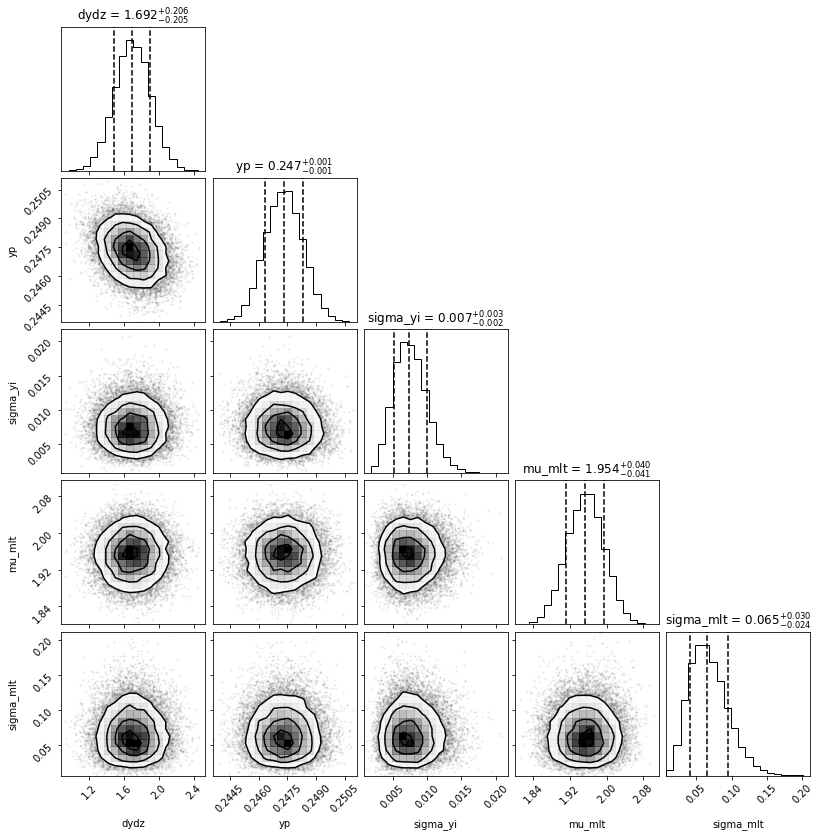

In [91]:
fig = corner(
    xs, quantiles=[.16, .5, .84],
    labels=phi, show_titles=True, title_fmt='.3f'
)

fig.savefig(os.path.join(path, 'corner_plot.png'))